In [1]:
import math

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import os

### Load & remove Data

In [13]:
def load_df_n_rmv_unnamed():
    data = pd.read_csv('./extract_seoul.csv')
    loc_df = pd.read_csv('./loc_df.csv')
    
    data = data.drop(['Unnamed: 0'],1)
    loc_df = loc_df.drop(['Unnamed: 0'], 1)
    
    data['Date'] = pd.to_datetime(data['Date'])
    
    return data, loc_df

In [14]:
data, loc_df = load_df_n_rmv_unnamed()

### GLOBAL VAR

In [267]:
GU_ENG_NAME = ''
BASE_PATH = './TimeSeries/'
MODEL_NAME = 'LSTM'

TRAIN_RATIO = 0.80
WINDOW_SIZE = 4

### Dict 관련 함수 선언

In [20]:
def create_dict(a, b):
    d = dict()
    #갯수 다르면
    if len(a)-len(b) != 0:
        for i in range(len(a)-len(b)):
            b.append(None)
    #갯수 같으면
    for j in range(len(a)):
        d[a[j]] = b[j]
    return d

In [21]:
def find_val_using_key(dic, key):
    if key in dic:
        return dic[key]
    else:
        print('404 not found')
        return dic['서울']

In [22]:
def find_key_using_val(dic, val):
    return [k for k, v in dic.items() if v == val][0]

### Loc code gen

In [23]:
def loc_code_dict_gen():
    loc_code = loc_df['구분']
    loc_code_en = loc_df['Classification']
    
    loc_code_dict = create_dict(loc_code, loc_code_en)
    
    return loc_code_dict

In [24]:
loc_code_dict = loc_code_dict_gen()

In [25]:
find_key_using_val(loc_code_dict, 'Total')

'전국'

In [26]:
find_val_using_key(loc_code_dict, '강남aaa')

404 not found


'Seoul'

### 원하는 구만 선택하기

In [333]:
def select_gu_data(df):
    gu_name = input()
    
    global GU_ENG_NAME
    search_name = find_val_using_key(loc_code_dict, gu_name)
    GU_ENG_NAME = search_name
    
    return df[['Date', search_name]]    

In [334]:
gu_data = select_gu_data(data)
print(GU_ENG_NAME)

강남구
Gangnam-gu


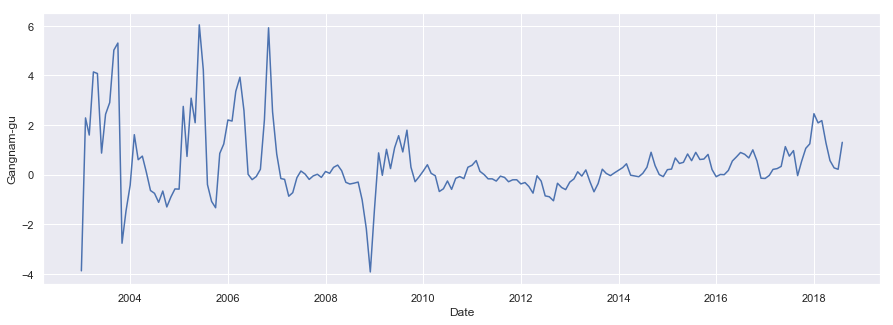

In [335]:
plt.figure(figsize = (15, 5))
ax = sns.lineplot(x="Date", y=GU_ENG_NAME, data=gu_data)

### Keras &  sklearn import

In [209]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import L1L2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

In [34]:
gu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
Date          188 non-null datetime64[ns]
Gangnam-gu    188 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


### Select Date Range

In [41]:
def select_date_range(data):
    year = input('연도 입력: ')
    month = input('월 입력: ')
    
    date_str = year +'-'+ str(int(month)).zfill(2) + '-01'
    
    mask = pd.to_datetime(date_str)
    
    result = data.loc[:][data['Date'] >= mask]
    
    return result

In [46]:
result_dataset = select_date_range(gu_data)

연도 입력: 2010
월 입력: 1


In [ ]:
result_dataset = result_dataset.set_index('Date')

### Keep

In [ ]:
gangnam_tmp['Gangnam-gu'] = gangnam_tmp['Gangnam-gu'] + 0.00001

In [ ]:
gangnam_tmp.values

### Normalize 0 ~ 1

In [58]:
def normalize_dataset(dataset):
    scaler = MinMaxScaler(feature_range = (0, 1))
    normed = scaler.fit_transform(dataset)
    
    return normed

In [444]:
normed_dataset = normalize_dataset(result_dataset)

In [445]:
tmp = np.array(list(map(lambda x: x+0.0000001, normed_dataset)))

In [446]:
tmp

array([[3.41613186e-01],
       [4.13997037e-01],
       [3.15157974e-01],
       [2.87644521e-01],
       [1.06591052e-01],
       [1.38135714e-01],
       [2.27369866e-01],
       [1.31451943e-01],
       [2.58126057e-01],
       [2.78120611e-01],
       [2.54534263e-01],
       [3.85182121e-01],
       [4.08071582e-01],
       [4.62026997e-01],
       [3.38023822e-01],
       [3.01291773e-01],
       [2.52185663e-01],
       [2.51854444e-01],
       [2.26522670e-01],
       [2.82905051e-01],
       [2.68344958e-01],
       [2.18848551e-01],
       [2.40984615e-01],
       [2.41567078e-01],
       [1.93963241e-01],
       [2.09396601e-01],
       [1.64116382e-01],
       [8.79489296e-02],
       [2.87153405e-01],
       [2.25773091e-01],
       [5.64980692e-02],
       [4.64182757e-02],
       [1.00000000e-07],
       [2.01615339e-01],
       [1.52618824e-01],
       [1.28398872e-01],
       [2.14440144e-01],
       [2.51186630e-01],
       [3.33349550e-01],
       [2.83974276e-01],


### split tran & test

In [268]:
def train_test_divide(data, train_ratio = 0.8):
    train_size = int(len(dataset) * train_ratio)
    test_size = len(dataset) - train_size
    
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    print("Number of entries (training set, test set): " + str((len(train), len(test))))
    
    return train, test

In [269]:
train, test = train_test_divide(normed_dataset, TRAIN_RATIO)

Number of entries (training set, test set): (83, 21)


In [276]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [277]:
train_X, train_Y = create_dataset(train, WINDOW_SIZE)
test_X, test_Y = create_dataset(test, WINDOW_SIZE)
whole_X, whole_Y = create_dataset(dataset, WINDOW_SIZE)

print("Original training data shape: ", train_X.shape, train_Y.shape)
print("Original test data shape: ", test_X.shape, test_Y.shape)
print("Original whole data shape: ", whole_X.shape, whole_Y.shape)

Original training data shape:  (78, 4) (78,)
Original test data shape:  (16, 4) (16,)
Original whole data shape:  (99, 4) (99,)


In [278]:
def reshape_dataset(train_x, test_x, whole_x):
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    whole_x = np.reshape(whole_x ,(whole_x.shape[0], 1, whole_x.shape[1]))
    
    print("train_X re-shape: ", train_x.shape)
    print("test_X re-shape: ", test_x.shape)
    print("whole_X re-shape: ", whole_x.shape)
    return train_x, test_x, whole_x

In [279]:
train_X, test_X, whole_X = reshape_dataset(train_X, test_X, whole_X)

train_X re-shape:  (78, 1, 4)
test_X re-shape:  (16, 1, 4)
whole_X re-shape:  (99, 1, 4)


### define Checkpoint

In [337]:
MODEL_PATH = ''
if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    global MODEL_PATH
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    
    
    MODEL_PATH = MODEL_PATH + "/" + GU_ENG_NAME
    print("Model_path : ", MODEL_PATH)
    
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=2,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=2, mode='min')

### define Model

In [338]:
def Model(train_X, train_Y, test_X, test_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM (256,  activation = 'relu', return_sequences = False ,inner_activation = 'hard_sigmoid' , bias_regularizer=L1L2(l1=0.01, l2=0.01),  input_shape =(1, window_size)))
    model.add(Dense(1))
    
#     adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    model.compile(loss = "mean_absolute_error", optimizer = adam)

    model.summary()
    
    history = model.fit(train_X, train_Y, epochs = 2000 ,batch_size=4, validation_data=(test_X, test_Y),
                        shuffle=False,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [339]:
model = Model(train_X, train_Y, test_X, test_Y, WINDOW_SIZE)

/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", return_sequences=False, bias_regularizer=<keras.reg..., input_shape=(1, 4), recurrent_activation="hard_sigmoid")`
  app.launch_new_instance()


Model_path :  ./TimeSeries/LSTM/Gangnam-gu
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Train on 78 samples, validate on 16 samples
Epoch 1/2000
78/78 [==============================] - 2s 32ms/step - loss: 5.3126 - val_loss: 5.3713

Epoch 00001: val_loss improved from inf to 5.37133, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.371331.hdf5
Epoch 2/2000
78/78 [==============================] - 0s 2ms/step - loss: 5.0477 - val_loss: 5.0551

Epoch 00002: val_loss improved from 5.37133 to 5.05509, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.055089.hdf

78/78 [==============================] - 0s 2ms/step - loss: 1.5151 - val_loss: 1.5419

Epoch 00034: val_loss improved from 1.61417 to 1.54189, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.541891.hdf5
Epoch 35/2000
78/78 [==============================] - 0s 2ms/step - loss: 1.4429 - val_loss: 1.4702

Epoch 00035: val_loss improved from 1.54189 to 1.47019, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.470189.hdf5
Epoch 36/2000
78/78 [==============================] - 0s 2ms/step - loss: 1.3748 - val_loss: 1.4024

Epoch 00036: val_loss improved from 1.47019 to 1.40240, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.402397.hdf5
Epoch 37/2000
78/78 [==============================] - 0s 2ms/step - loss: 1.3073 - val_loss: 1.3372

Epoch 00037: val_loss improved from 1.40240 to 1.33717, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.337169.hdf5
Epoch 38/2000
78/78 [==============================] - 0s 2ms/step - loss: 1.2415 - val_loss: 1.2728

Epoch 00

78/78 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.1219

Epoch 00071: val_loss improved from 0.12236 to 0.12191, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.121909.hdf5
Epoch 72/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.1231

Epoch 00072: val_loss did not improve from 0.12191
Epoch 73/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.1219

Epoch 00073: val_loss did not improve from 0.12191
Epoch 74/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0676 - val_loss: 0.1218

Epoch 00074: val_loss improved from 0.12191 to 0.12181, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.121807.hdf5
Epoch 75/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.1237

Epoch 00075: val_loss did not improve from 0.12181
Epoch 76/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.1222

E

78/78 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.1221

Epoch 00121: val_loss did not improve from 0.11773
Epoch 122/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.1188

Epoch 00122: val_loss did not improve from 0.11773
Epoch 123/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.1257

Epoch 00123: val_loss did not improve from 0.11773
Epoch 124/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.1200

Epoch 00124: val_loss did not improve from 0.11773
Epoch 125/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.1239

Epoch 00125: val_loss did not improve from 0.11773
Epoch 126/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.1213

Epoch 00126: val_loss did not improve from 0.11773
Epoch 127/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0639 - val_lo

In [375]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    gt_val = scaler.inverse_transform([Y])
    
    print(len(gt_val[0]))
    print(len(pred[:, 0]))
    
    #RMSE.
    rmse = math.sqrt(mean_squared_error(gt_val[0], pred[:, 0]))
    
    #MAE
    mae = mean_absolute_error(gt_val[0], pred[:, 0])
    
    return(rmse, mae, pred, gt_val)

In [376]:
rmse_train, mae_train, train_predict, train_orig = predict_and_score(model[0], train_X, train_Y)
rmse_test, mae_test, test_predict, test_orig = predict_and_score(model[0], test_X, test_Y)
whole_test,mae_whole, whole_predict, whole_orig = predict_and_score(model[0], whole_X, whole_Y)

print("Training data score: %.2f RMSE, %.2f MAE"% (rmse_train, mae_train))
print("Test data score: %.2f RMSE, %.2f MAE"% (rmse_test, mae_test))
print("Whole data score: %.2f RMSE, %.2f MAE"% (whole_test, mae_whole))

78
78
16
16
99
99
Training data score: 0.26 RMSE, 0.21 MAE
Test data score: 0.62 RMSE, 0.48 MAE
Whole data score: 0.34 RMSE, 0.25 MAE


In [377]:
def start_predict_n_plot(dataset, train_predict, test_predict):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[WINDOW_SIZE - 1:len(train_predict) + WINDOW_SIZE - 1, :] = train_predict

    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + (WINDOW_SIZE * 2) :len(dataset) - 2 , :] = test_predict
    
    print(test_predict_plot.shape)
    
    title_label = GU_ENG_NAME + " Train / Test Predict"

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(train_predict_plot, label = "Training set pred")
    plt.plot(test_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title(title_label)
    plt.legend()
    plt.show()

(104, 1)


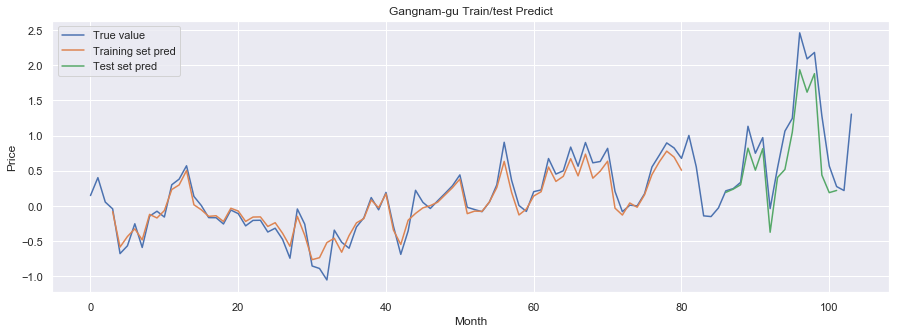

In [378]:
start_predict_n_plot(dataset, train_predict, test_predict)

## Predict Future

In [380]:
whole_predict[-window_size:]

array([[1.8791988 ],
       [0.4381789 ],
       [0.18817328],
       [0.2193487 ]], dtype=float32)

In [381]:
def predict_future(model, X, window_size):
    
    trans = X[-window_size:].T
    
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
    return pred

In [382]:
future_pred = predict_future(model[0], whole_predict, WINDOW_SIZE)

pred:  [[1.1985]]


In [385]:
def make_future_data(model, predict, nb_future):
    for i in range(nb_future):
        print("len before: ", len(predict))
        future_pred = predict_future(model, predict, WINDOW_SIZE)
        predict = np.append(predict, future_pred, axis=0)
        
    return predict

In [425]:
after_pred_data = make_future_data(model[0] ,whole_predict, 4)

len before:  99
pred:  [[1.1985]]
len before:  100
pred:  [[0.53852576]]
len before:  101
pred:  [[-0.09928397]]
len before:  102
pred:  [[-0.47062457]]


In [426]:
def whole_predict_n_plot(dataset, predict):
    
    true_value_plot = np.empty_like(dataset)
    print(true_value_plot.shape)
    print(whole_predict.shape)
    
    print('dataset_len : ', len(dataset))
    print('whole_predict_len : ', len(predict))
    
    
#     test_predict_plot[:, :] = np.nan
#     test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict

    whole_predict_plot = np.empty_like(predict)
    whole_predict_plot[:, :] = predict
    
    for i in range(WINDOW_SIZE - 1):
        whole_predict_plot = np.insert(whole_predict_plot, 0, 0)
    
    title_label = GU_ENG_NAME + " Train / Test Predict"
    
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title(title_label)
    plt.legend()
    plt.show()

(104, 1)
(99, 1)
dataset_len :  104
whole_predict_len :  103


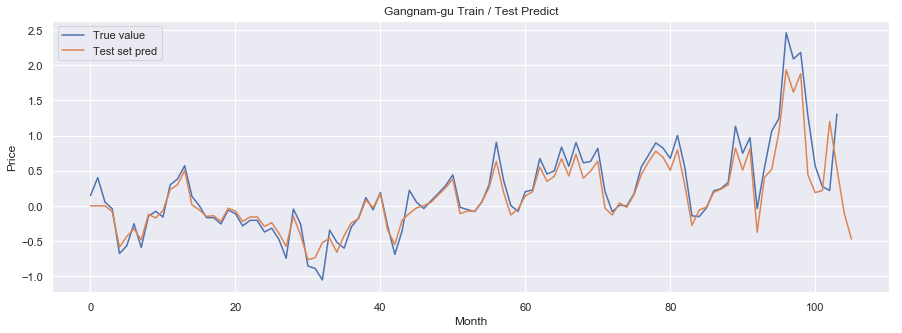

In [427]:
whole_predict_n_plot(dataset, after_pred_data)

### LSTM cross validation

In [66]:
X, y = create_dataset(normed_dataset, window_size)

In [67]:
X[:5]

array([[0.34161309, 0.41399694, 0.31515787, 0.28764442],
       [0.41399694, 0.31515787, 0.28764442, 0.10659095],
       [0.31515787, 0.28764442, 0.10659095, 0.13813561],
       [0.28764442, 0.10659095, 0.13813561, 0.22736977],
       [0.10659095, 0.13813561, 0.22736977, 0.13145184]])

In [68]:
y[:5]

array([0.10659095, 0.13813561, 0.22736977, 0.13145184, 0.25812596])

In [70]:
tscv = TimeSeriesSplit(n_splits=10)

In [ ]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    model = Model(X_train, y_train, X_test, y_test, window_size)
    
    best_weights = get_best_weights_path()
    model[0].load_weights(best_weights)
    
    plt.figure(figsize = (15, 5))
    plt.plot(model[1].history['loss'], label='train')
    plt.plot(model[1].history['val_loss'], label='test')
    plt.ylim([0.0, 0.05])
    plt.legend()
    plt.show()
    
    reshaped_X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    pred = scaler.inverse_transform(model[0].predict(reshaped_X))
    orig_data = scaler.inverse_transform([y])
    
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(pred[:, 0], label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()
    
    whole_predict = pred[:, 0]
    for i in range(10):
        future_pred = predict_future(model[0], whole_predict, window_size)
        whole_predict.shape = (whole_predict.size//1, 1)
        whole_predict = np.append(whole_predict, future_pred, axis=0)
        
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Whole Predict")
    plt.legend()
    plt.show()

In [ ]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    best_weights = get_best_weights_path()
    model[0].load_weights(best_weights)
    
    loaded_model = run_loaded_model(model[0], X_train, y_train, X_test, y_test, window_size)

In [ ]:
def predict_future(model, X, window_size):
    
    print('X shape: ', X.shape)
    
    trans = X[-window_size:].T
    print("trans: ", trans)
    print("type: ", type(trans))
    trans.shape = (trans.size//1, 1)
    print("trans: ", trans)
    print("trans shape: ", trans.shape)
    print("trans shape[0]: ", trans.shape[0])
    print("trans shape[1]1: ", trans.shape[1])
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    tmp_shape = tmp_shape.T
    print("tmp_shape: ", tmp_shape)
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
#     print(pred[0])
    return pred

In [ ]:
whole_predict = pred[:, 0]

In [ ]:
for i in range(10):
    future_pred = predict_future(loaded_model[0], whole_predict, window_size)
    whole_predict.shape = (whole_predict.size//1, 1)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
test_predict_plot = np.empty_like(whole_predict)
print(len(test_predict_plot))
print(len(whole_predict))


print(test_predict_plot)
test_predict_plot[:, :] = np.nan
test_predict_plot[:, :] = whole_predict

# test_predict_plot = np.insert(test_predict_plot, 0, np.nan, axis=1)

test_predict_plot = np.insert(test_predict_plot, 0, 0)

In [ ]:
test_predict_plot = np.insert(test_predict_plot, 0, 0)

In [ ]:
test_predict_plot = np.delete(test_predict_plot, 0)

In [ ]:
print(len(test_predict_plot))

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(test_predict_plot, label = "Test set pred")
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Gangnam Train/test Predict")
plt.legend()
plt.show()

In [ ]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
whole_X = np.reshape(whole_X, (whole_X.shape[0], 1, whole_X.shape[1]))

print("New training data shape:")
print(train_X.shape)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
 
T=25
history_val_loss=[]
 
for x in loaded_model[1].history['val_loss']:
    if x >= T:
        history_val_loss.append (T)
    else:
        history_val_loss.append( x )
        
plt.figure(figsize = (15, 15))
plt.plot(loaded_model[1].history['loss'])
plt.plot(history_val_loss)
plt.ylim([0.0, 0.05])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

### get Best weights model

In [447]:
def ignore_hidden_file(fname):
    return not fname.startswith(".")

In [448]:
def get_best_weights_path():
    file_list = os.listdir(MODEL_PATH)
    not_hidden_files = list(filter(ignore_hidden_file, file_list))
    result = MODEL_PATH + "/" + sorted(not_hidden_files)[0]
    print("Best weight path: ", result)
    
    return result

In [449]:
best_weights = get_best_weights_path()

Best weight path:  ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.003408.hdf5


In [368]:
def run_loaded_model(model, train_X, train_Y, X_test,y_test, window_size = 1):
#     adam = Adam(lr=0.00146, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)
    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    history = model.fit(train_X, train_Y, epochs = 1000 ,batch_size=4,  validation_data=(X_test, y_test),
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [370]:
model[0].load_weights(best_weights)

loaded_model = run_loaded_model(model[0], train_X, train_Y, test_X, test_Y, WINDOW_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM/Gangnam-gu
Train on 78 samples, validate on 16 samples
Epoch 1/1000
78/78 [==============================] - 2s 28ms/step - loss: 0.0089 - val_loss: 0.0272

Epoch 00001: val_loss improved from inf to 0.02716, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.027159.hdf5
Epoch 2/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0273

Epoch 00002: val_loss did not improve from 0.02716
Epoch 3/1000
78/78 [==============================] - 0s 2ms/step - los


Epoch 00049: val_loss did not improve from 0.02716
Epoch 50/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0281

Epoch 00050: val_loss did not improve from 0.02716
Epoch 51/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0291

Epoch 00051: val_loss did not improve from 0.02716
Epoch 52/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0297

Epoch 00052: val_loss did not improve from 0.02716
Epoch 53/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0297

Epoch 00053: val_loss did not improve from 0.02716
Epoch 54/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0323

Epoch 00054: val_loss did not improve from 0.02716
Epoch 55/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0282

Epoch 00055: val_loss did not improve from 0.02716
Epoch 56/1000
78/78 [=========

In [450]:
def mape(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    Y, pred = np.array(Y), np.array(pred)
    
    return np.mean(np.abs((Y - pred) / Y) * 100)

In [372]:
rmse_train_score, train_predict, train_orig = predict_and_score(loaded_model[0], train_X, train_Y)
rmse_test_score, test_predict, test_orig = predict_and_score(loaded_model[0], test_X, test_Y)
whole_test_score, whole_predict, whole_orig = predict_and_score(loaded_model[0], whole_X, whole_Y)

print(whole_X[:5])
print(whole_Y[:5])
print('\n')
print("Training data score: %.2f RMSE" % rmse_train_score)
print("Test data score: %.2f RMSE" % rmse_test_score)
print("Whole data score: %.2f RMSE " % whole_test_score)

78
78


ValueError: too many values to unpack (expected 3)

In [373]:
mape(loaded_model[0], whole_X, whole_Y)

[0.10659095 0.13813561 0.22736977 0.13145184 0.25812596 0.27812051
 0.25453416 0.38518202 0.40807148 0.4620269  0.33802372 0.30129167
 0.25218556 0.25185434 0.22652257 0.28290495 0.26834486 0.21884845
 0.24098452 0.24156698 0.19396314 0.2093965  0.16411628 0.08794883
 0.28715331 0.22577299 0.05649797 0.04641818 0.         0.20161524
 0.15261872 0.12839877 0.21444004 0.25118653 0.33334945 0.28397418
 0.35422305 0.21846023 0.1035275  0.19847166 0.36285748 0.31389134
 0.28915095 0.32058684 0.35040944 0.38134575 0.42511862 0.29389887
 0.28488724 0.27628444 0.31520855 0.38508898 0.55716881 0.40362303
 0.30120879 0.2773862  0.35730569 0.36433045 0.49143759 0.42841529
 0.44176772 0.53767965 0.46023509 0.55624173 0.47401032 0.47940637
 0.53259242 0.3582441  0.2762441  0.30230675 0.29977363 0.34882988
 0.45702492 0.50500588 0.55460901 0.53408034 0.49204532 0.58487411
 0.45765257 0.25938263 0.25646361 0.29139648 0.36069062 0.3696295
 0.39489294 0.62186079 0.51272798 0.57618473 0.28876648 0.45369

/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide


inf

In [ ]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

In [ ]:
whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
for i in range(10):
    print("len before: ", len(whole_predict))
    future_pred = predict_future(model[0], whole_predict, window_size)
    
    print("future_pred")
    print(future_pred)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

In [374]:
whole_predict_n_plot(dataset, train_predict)

(104, 1)
(103, 1)
dataset_len :  104
whole_predict_len :  78


ValueError: could not broadcast input array from shape (100,1) into shape (75,1)